# C2T4 - EMG Gesture Classifier (Capstone)

**Derek Andersen**

Last update: 2022.06.20

## Import all required modules

In [259]:
# core
import numpy as np
import pandas as pd
import scipy
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns

# SKLearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# models
from sklearn.metrics import get_scorer_names
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, StackingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# save trained models with joblib
import joblib

# Dataset - Electromyography for static gesture recognition

**Dataset source**: [EMG Data for Gestures](https://archive.ics.uci.edu/ml/datasets/EMG+data+for+gestures)

**Overview**: Data captured with MYO Thalmic bracelet on forearm, 8 EMG sensors, raw data for 36 subjects while they performed a series of static hand gestures, 8 class labels for gestures.

**Description of raw_data_* file**:

Each file consists of 10 columns:
- 1) Time - time in ms;
- 2-9) Channel - eight EMG channels of MYO Thalmic bracelet;
- 10) Class – the label of gestures: 
    - 0 - unmarked data,
    - 1 - hand at rest, 
    - 2 - hand clenched in a fist, 
    - 3 - wrist flexion,
    - 4 – wrist extension,
    - 5 – radial deviations,
    - 6 - ulnar deviations,
    - 7 - extended palm (the gesture was not performed by all subjects).

Each of the 36 subjects performed a series of hand gestures twice for a total of 72 individual raw data files.

Each raw data file consists of tab-separated values for each of the 10 columns above.

Note that there are no columns in the raw data that indicate either the subject number or the series number. The series number won't be used here, but the subject number will be included for some alternative model testing--under the assumption that, perhaps, our gesture recognition classifier might be more accurate if it is trained and tested against just one user's observations.

In [2]:
# import dataset (example: first series for subject 1)
df = pd.read_csv("EMG_data_for_gestures-master/01/1_raw_data_13-12_22.03.16.txt", sep='\t')

In [3]:
# add a column to represent the subject number
df['subject'] = 1

In [4]:
df.shape

(63196, 11)

In [5]:
df.head()

,time,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,class,subject
0,1,0.00001,-0.00002,-0.00001,-0.00003,0.00000,-0.00001,0.00000,-0.00001,0,1
1,5,0.00001,-0.00002,-0.00001,-0.00003,0.00000,-0.00001,0.00000,-0.00001,0,1
2,6,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,0,1
3,7,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,0,1
4,8,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,0,1


In [6]:
df.describe()

,time,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,class,subject
count,63196.000000,63196.000000,63196.000000,63196.000000,63196.000000,63196.000000,63196.00000,63196.000000,63196.000000,63196.000000,63196.0
mean,32777.490094,-0.000008,-0.000009,-0.000009,-0.000010,-0.000012,-0.00001,-0.000008,-0.000008,1.212086,1.0
std,18943.835626,0.000144,0.000134,0.000124,0.000155,0.000198,0.00016,0.000133,0.000142,1.947578,0.0
min,1.000000,-0.001110,-0.001020,-0.000910,-0.001040,-0.001280,-0.00112,-0.001090,-0.000980,0.000000,1.0
25%,16340.750000,-0.000030,-0.000040,-0.000050,-0.000040,-0.000040,-0.00004,-0.000030,-0.000030,0.000000,1.0
50%,32781.500000,-0.000010,-0.000010,-0.000010,-0.000010,-0.000010,-0.00001,-0.000010,-0.000010,0.000000,1.0
75%,49199.250000,0.000010,0.000020,0.000030,0.000020,0.000010,0.00001,0.000010,0.000010,2.000000,1.0
max,65661.000000,0.001270,0.001270,0.001270,0.001270,0.001270,0.00127,0.001270,0.001270,6.000000,1.0


In [7]:
# Read in the rest of the datasets, add the 'subject' column, and append them to the primary dataframe
# (The raw data could have been concatenated and processed outside the notebook, but this way the full pipeline 
# is preserved in the notebook itself.)
df_01_2 = pd.read_csv("EMG_data_for_gestures-master/01/2_raw_data_13-13_22.03.16.txt", sep="\t")
df_01_2['subject'] = 1
df_02_1 = pd.read_csv("EMG_data_for_gestures-master/02/1_raw_data_14-19_22.03.16.txt", sep="\t")
df_02_1['subject'] = 2
df_02_2 = pd.read_csv("EMG_data_for_gestures-master/02/2_raw_data_14-21_22.03.16.txt", sep="\t")
df_02_2['subject'] = 2
df_03_1 = pd.read_csv("EMG_data_for_gestures-master/03/1_raw_data_09-32_11.04.16.txt", sep="\t")
df_03_1['subject'] = 3
df_03_2 = pd.read_csv("EMG_data_for_gestures-master/03/2_raw_data_09-34_11.04.16.txt", sep="\t")
df_03_2['subject'] = 3
df_04_1 = pd.read_csv("EMG_data_for_gestures-master/04/1_raw_data_18-02_24.04.16.txt", sep="\t")
df_04_1['subject'] = 4
df_04_2 = pd.read_csv("EMG_data_for_gestures-master/04/2_raw_data_18-03_24.04.16.txt", sep="\t")
df_04_2['subject'] = 4
df_05_1 = pd.read_csv("EMG_data_for_gestures-master/05/1_raw_data_10-28_30.03.16.txt", sep="\t")
df_05_1['subject'] = 5
df_05_2 = pd.read_csv("EMG_data_for_gestures-master/05/2_raw_data_10-29_30.03.16.txt", sep="\t")
df_05_2['subject'] = 5
df_06_1 = pd.read_csv("EMG_data_for_gestures-master/06/1_raw_data_10-38_11.04.16.txt", sep="\t")
df_06_1['subject'] = 6
df_06_2 = pd.read_csv("EMG_data_for_gestures-master/06/2_raw_data_10-40_11.04.16.txt", sep="\t")
df_06_2['subject'] = 6
df_07_1 = pd.read_csv("EMG_data_for_gestures-master/07/1_raw_data_18-48_22.03.16.txt", sep="\t")
df_07_1['subject'] = 7
df_07_2 = pd.read_csv("EMG_data_for_gestures-master/07/2_raw_data_18-50_22.03.16.txt", sep="\t")
df_07_2['subject'] = 7
df_08_1 = pd.read_csv("EMG_data_for_gestures-master/08/1_raw_data_12-14_23.03.16.txt", sep="\t")
df_08_1['subject'] = 8
df_08_2 = pd.read_csv("EMG_data_for_gestures-master/08/2_raw_data_12-16_23.03.16.txt", sep="\t")
df_08_2['subject'] = 8
df_09_1 = pd.read_csv("EMG_data_for_gestures-master/09/1_raw_data_12-41_23.03.16.txt", sep="\t")
df_09_1['subject'] = 9
df_09_2 = pd.read_csv("EMG_data_for_gestures-master/09/2_raw_data_12-43_23.03.16.txt", sep="\t")
df_09_2['subject'] = 9
df_10_1 = pd.read_csv("EMG_data_for_gestures-master/10/1_raw_data_11-08_21.03.16.txt", sep="\t")
df_10_1['subject'] = 10
df_10_2 = pd.read_csv("EMG_data_for_gestures-master/10/2_raw_data_11-10_21.03.16.txt", sep="\t")
df_10_2['subject'] = 10
df_11_1 = pd.read_csv("EMG_data_for_gestures-master/11/1_raw_data_13-11_18.03.16.txt", sep="\t")
df_11_1['subject'] = 11
df_11_2 = pd.read_csv("EMG_data_for_gestures-master/11/2_raw_data_13-13_18.03.16.txt", sep="\t")
df_11_2['subject'] = 11
df_12_1 = pd.read_csv("EMG_data_for_gestures-master/12/1_raw_data_11-35_28.03.16.txt", sep="\t")
df_12_1['subject'] = 12
df_12_2 = pd.read_csv("EMG_data_for_gestures-master/12/2_raw_data_11-36_28.03.16.txt", sep="\t")
df_12_2['subject'] = 12
df_13_1 = pd.read_csv("EMG_data_for_gestures-master/13/1_raw_data_13-26_21.03.16.txt", sep="\t")
df_13_1['subject'] = 13
df_13_2 = pd.read_csv("EMG_data_for_gestures-master/13/2_raw_data_13-29_21.03.16.txt", sep="\t")
df_13_2['subject'] = 13
df_14_1 = pd.read_csv("EMG_data_for_gestures-master/14/1_raw_data_09-50_15.04.16.txt", sep="\t")
df_14_1['subject'] = 14
df_14_2 = pd.read_csv("EMG_data_for_gestures-master/14/2_raw_data_09-51_15.04.16.txt", sep="\t")
df_14_2['subject'] = 14
df_15_1 = pd.read_csv("EMG_data_for_gestures-master/15/1_raw_data_08-49_13.04.16.txt", sep="\t")
df_15_1['subject'] = 15
df_15_2 = pd.read_csv("EMG_data_for_gestures-master/15/2_raw_data_08-51_13.04.16.txt", sep="\t")
df_15_2['subject'] = 15
df_16_1 = pd.read_csv("EMG_data_for_gestures-master/16/1_raw_data_12-12_25.04.16.txt", sep="\t")
df_16_1['subject'] = 16
df_16_2 = pd.read_csv("EMG_data_for_gestures-master/16/2_raw_data_12-14_25.04.16.txt", sep="\t")
df_16_2['subject'] = 16
df_17_1 = pd.read_csv("EMG_data_for_gestures-master/17/1_raw_data_11-19_23.03.16.txt", sep="\t")
df_17_1['subject'] = 17
df_17_2 = pd.read_csv("EMG_data_for_gestures-master/17/2_raw_data_11-20_23.03.16.txt", sep="\t")
df_17_2['subject'] = 17
df_18_1 = pd.read_csv("EMG_data_for_gestures-master/18/1_raw_data_12-35_21.03.16.txt", sep="\t")
df_18_1['subject'] = 18
df_18_2 = pd.read_csv("EMG_data_for_gestures-master/18/2_raw_data_12-37_21.03.16.txt", sep="\t")
df_18_2['subject'] = 18
df_19_1 = pd.read_csv("EMG_data_for_gestures-master/19/1_raw_data_12-10_26.04.16.txt", sep="\t")
df_19_1['subject'] = 19
df_19_2 = pd.read_csv("EMG_data_for_gestures-master/19/2_raw_data_12-11_26.04.16.txt", sep="\t")
df_19_2['subject'] = 19
df_20_1 = pd.read_csv("EMG_data_for_gestures-master/20/1_raw_data_11-41_22.03.16.txt", sep="\t")
df_20_1['subject'] = 20
df_20_2 = pd.read_csv("EMG_data_for_gestures-master/20/2_raw_data_11-43_22.03.16.txt", sep="\t")
df_20_2['subject'] = 20
df_21_1 = pd.read_csv("EMG_data_for_gestures-master/21/1_raw_data_20-28_24.04.16.txt", sep="\t")
df_21_1['subject'] = 21
df_21_2 = pd.read_csv("EMG_data_for_gestures-master/21/2_raw_data_20-30_24.04.16.txt", sep="\t")
df_21_2['subject'] = 21
df_22_1 = pd.read_csv("EMG_data_for_gestures-master/22/1_raw_data_12-37_28.03.16.txt", sep="\t")
df_22_1['subject'] = 22
df_22_2 = pd.read_csv("EMG_data_for_gestures-master/22/2_raw_data_12-39_28.03.16.txt", sep="\t")
df_22_2['subject'] = 22
df_23_1 = pd.read_csv("EMG_data_for_gestures-master/23/1_raw_data_13-18_05.04.16.txt", sep="\t")
df_23_1['subject'] = 23
df_23_2 = pd.read_csv("EMG_data_for_gestures-master/23/2_raw_data_13-19_05.04.16.txt", sep="\t")
df_23_2['subject'] = 23
df_24_1 = pd.read_csv("EMG_data_for_gestures-master/24/1_raw_data_10-16_12.04.16.txt", sep="\t")
df_24_1['subject'] = 24
df_24_2 = pd.read_csv("EMG_data_for_gestures-master/24/2_raw_data_10-17_12.04.16.txt", sep="\t")
df_24_2['subject'] = 24
df_25_1 = pd.read_csv("EMG_data_for_gestures-master/25/1_raw_data_14-51_24.04.16.txt", sep="\t")
df_25_1['subject'] = 25
df_25_2 = pd.read_csv("EMG_data_for_gestures-master/25/2_raw_data_14-53_24.04.16.txt", sep="\t")
df_25_2['subject'] = 25
df_26_1 = pd.read_csv("EMG_data_for_gestures-master/26/1_raw_data_10-22_29.03.16.txt", sep="\t")
df_26_1['subject'] = 26
df_26_2 = pd.read_csv("EMG_data_for_gestures-master/26/2_raw_data_10-23_29.03.16.txt", sep="\t")
df_26_2['subject'] = 26
df_27_1 = pd.read_csv("EMG_data_for_gestures-master/27/1_raw_data_12-19_06.04.16.txt", sep="\t")
df_27_1['subject'] = 27
df_27_2 = pd.read_csv("EMG_data_for_gestures-master/27/2_raw_data_12-20_06.04.16.txt", sep="\t")
df_27_2['subject'] = 27
df_28_1 = pd.read_csv("EMG_data_for_gestures-master/28/1_raw_data_12-10_15.04.16.txt", sep="\t")
df_28_1['subject'] = 28
df_28_2 = pd.read_csv("EMG_data_for_gestures-master/28/2_raw_data_12-11_15.04.16.txt", sep="\t")
df_28_2['subject'] = 28
df_29_1 = pd.read_csv("EMG_data_for_gestures-master/29/1_raw_data_10-17_15.04.16.txt", sep="\t")
df_29_1['subject'] = 29
df_29_2 = pd.read_csv("EMG_data_for_gestures-master/29/2_raw_data_10-18_15.04.16.txt", sep="\t")
df_29_2['subject'] = 29
df_30_1 = pd.read_csv("EMG_data_for_gestures-master/30/1_raw_data_09-49_21.03.16.txt", sep="\t")
df_30_1['subject'] = 30
df_30_2 = pd.read_csv("EMG_data_for_gestures-master/30/2_raw_data_09-50_21.03.16.txt", sep="\t")
df_30_2['subject'] = 30
df_31_1 = pd.read_csv("EMG_data_for_gestures-master/31/1_raw_data_11-15_11.04.16.txt", sep="\t")
df_31_1['subject'] = 31
df_31_2 = pd.read_csv("EMG_data_for_gestures-master/31/2_raw_data_11-16_11.04.16.txt", sep="\t")
df_31_2['subject'] = 31
df_32_1 = pd.read_csv("EMG_data_for_gestures-master/32/1_raw_data_12-04_27.04.16.txt", sep="\t")
df_32_1['subject'] = 32
df_32_2 = pd.read_csv("EMG_data_for_gestures-master/32/2_raw_data_12-06_27.04.16.txt", sep="\t")
df_32_2['subject'] = 32
df_33_1 = pd.read_csv("EMG_data_for_gestures-master/33/1_raw_data_09-49_12.04.16.txt", sep="\t")
df_33_1['subject'] = 33
df_33_2 = pd.read_csv("EMG_data_for_gestures-master/33/2_raw_data_09-50_12.04.16.txt", sep="\t")
df_33_2['subject'] = 33
df_34_1 = pd.read_csv("EMG_data_for_gestures-master/34/1_raw_data_10-51_07.04.16.txt", sep="\t")
df_34_1['subject'] = 34
df_34_2 = pd.read_csv("EMG_data_for_gestures-master/34/2_raw_data_10-53_07.04.16.txt", sep="\t")
df_34_2['subject'] = 34
df_35_1 = pd.read_csv("EMG_data_for_gestures-master/35/1_raw_data_10-03_13.04.16.txt", sep="\t")
df_35_1['subject'] = 35
df_35_2 = pd.read_csv("EMG_data_for_gestures-master/35/2_raw_data_10-05_13.04.16.txt", sep="\t")
df_35_2['subject'] = 35
df_36_1 = pd.read_csv("EMG_data_for_gestures-master/36/1_raw_data_13-03_15.04.16.txt", sep="\t")
df_36_1['subject'] = 36
df_36_2 = pd.read_csv("EMG_data_for_gestures-master/36/2_raw_data_13-04_15.04.16.txt", sep="\t")
df_36_2['subject'] = 36
df = pd.concat([df, df_01_2, df_02_1, df_02_2, df_03_1, df_03_2, df_04_1, df_04_2, df_05_1, df_05_2, 
                 df_06_1, df_06_2, df_07_1, df_07_2, df_08_1, df_08_2, df_09_1, df_09_2, df_10_1, df_10_2, 
                 df_11_1, df_11_2, df_12_1, df_12_2, df_13_1, df_13_2, df_14_1, df_14_2, df_15_1, df_15_2, 
                 df_16_1, df_16_2, df_17_1, df_17_2, df_18_1, df_18_2, df_19_1, df_19_2, df_20_1, df_20_2, 
                 df_21_1, df_21_2, df_22_1, df_22_2, df_23_1, df_23_2, df_24_1, df_24_2, df_25_1, df_25_2, 
                 df_26_1, df_26_2, df_27_1, df_27_2, df_28_1, df_28_2, df_29_1, df_29_2, df_30_1, df_30_2, 
                 df_31_1, df_31_2, df_32_1, df_32_2, df_33_1, df_33_2, df_34_1, df_34_2, df_35_1, df_35_2, 
                 df_36_1, df_36_2])
df.shape

(4237908, 11)

In [8]:
df.describe()

,time,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,class,subject
count,4.237908e+06,4.237908e+06,4.237908e+06,4.237908e+06,4.237908e+06,4.237908e+06,4.237908e+06,4.237908e+06,4.237908e+06,4.237907e+06,4.237908e+06
mean,3.113689e+04,-7.911481e-06,-9.416077e-06,-9.548735e-06,-9.637838e-06,-1.599724e-05,-1.085528e-05,-9.364637e-06,-9.696860e-06,1.265671e+00,1.819389e+01
std,1.868079e+04,1.631110e-04,1.192228e-04,1.241846e-04,2.257728e-04,2.724188e-04,2.151405e-04,1.527311e-04,1.720933e-04,1.989693e+00,1.029516e+01
min,0.000000e+00,-1.280000e-03,-1.280000e-03,-1.280000e-03,-1.280000e-03,-1.280000e-03,-1.280000e-03,-1.280000e-03,-1.280000e-03,0.000000e+00,1.000000e+00
25%,1.529000e+04,-3.000000e-05,-4.000000e-05,-4.000000e-05,-6.000000e-05,-8.000000e-05,-6.000000e-05,-4.000000e-05,-3.000000e-05,0.000000e+00,9.000000e+00
50%,3.054600e+04,-1.000000e-05,-1.000000e-05,-1.000000e-05,-1.000000e-05,-1.000000e-05,-1.000000e-05,-1.000000e-05,-1.000000e-05,0.000000e+00,1.800000e+01
75%,4.580400e+04,2.000000e-05,2.000000e-05,3.000000e-05,4.000000e-05,5.000000e-05,3.000000e-05,2.000000e-05,1.000000e-05,2.000000e+00,2.700000e+01
max,9.714400e+04,1.270000e-03,1.270000e-03,1.270000e-03,1.270000e-03,1.270000e-03,1.270000e-03,1.270000e-03,1.270000e-03,7.000000e+00,3.600000e+01


In [9]:
df.head()

,time,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,class,subject
0,1,0.00001,-0.00002,-0.00001,-0.00003,0.00000,-0.00001,0.00000,-0.00001,0.0,1
1,5,0.00001,-0.00002,-0.00001,-0.00003,0.00000,-0.00001,0.00000,-0.00001,0.0,1
2,6,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,0.0,1
3,7,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,0.0,1
4,8,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,0.0,1


## Preprocess dataset
### Steps to preprocess dataset
* Change col labels
* Sort
* Remove cols 
* Add NaNs and remove
* Remove duplicates
* Use iloc to create new ds
* Write/read csv


In [10]:
# Change column labels - not applicable
# Sort - not applicable
# Remove rows with labels and col ID - not applicable

In [10]:
# Replace missing values, other with NaN and then drop
df = df.replace(['','?'], np.nan)
df[df.isnull().values]
df = df.dropna()
df.isnull().values.any()
df.shape

(4237907, 11)

In [11]:
# Remove any duplicates
df.duplicated().any()
df[df.duplicated()].shape
df = df.drop_duplicates()
df.duplicated().any()
df.shape

(4237907, 11)

In [28]:
# Rename feature - not applicable

In [12]:
df.dtypes

time          int64
channel1    float64
channel2    float64
channel3    float64
channel4    float64
channel5    float64
channel6    float64
channel7    float64
channel8    float64
class       float64
subject       int64
dtype: object

In [13]:
# "class" should not be a float64, so we'll convert it to a Pandas "category"
df["class"] = df["class"].astype("category")
df.dtypes

time           int64
channel1     float64
channel2     float64
channel3     float64
channel4     float64
channel5     float64
channel6     float64
channel7     float64
channel8     float64
class       category
subject        int64
dtype: object

In [14]:
# "subject" should also not be an int64, so we'll convert it to a Pandas "category"
df["subject"] = df["subject"].astype("category")
df.dtypes

time           int64
channel1     float64
channel2     float64
channel3     float64
channel4     float64
channel5     float64
channel6     float64
channel7     float64
channel8     float64
class       category
subject     category
dtype: object

In [24]:
# change data types by write/read csv

# write csv 
df.to_csv('dfOOB.csv', index=False)

In [2]:
# read csv
df = pd.read_csv('dfOOB.csv')

In [3]:
# Note that the "class" column has been turned back into a float64 and the "subject" column has been turned back
# into an in64, so if we want to reuse this we need to change the types again
df.dtypes

time          int64
channel1    float64
channel2    float64
channel3    float64
channel4    float64
channel5    float64
channel6    float64
channel7    float64
channel8    float64
class       float64
subject       int64
dtype: object

In [4]:
# "class" should not be a float64, so we'll convert it to a Pandas "category"
df["class"] = df["class"].astype("category")
# "subject" should also not be an int64, so we'll convert it to a Pandas "category"
df["subject"] = df["subject"].astype("category")
df.dtypes

time           int64
channel1     float64
channel2     float64
channel3     float64
channel4     float64
channel5     float64
channel6     float64
channel7     float64
channel8     float64
class       category
subject     category
dtype: object

# Task 2 - EDA

In [218]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4237907 entries, 0 to 49363
Data columns (total 11 columns):
 #   Column    Dtype   
---  ------    -----   
 0   time      int64   
 1   channel1  float64 
 2   channel2  float64 
 3   channel3  float64 
 4   channel4  float64 
 5   channel5  float64 
 6   channel6  float64 
 7   channel7  float64 
 8   channel8  float64 
 9   class     category
 10  subject   category
dtypes: category(2), float64(8), int64(1)
memory usage: 363.7 MB


In [16]:
df.head()

,time,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,class,subject
0,1,0.00001,-0.00002,-0.00001,-0.00003,0.00000,-0.00001,0.00000,-0.00001,0.0,1
1,5,0.00001,-0.00002,-0.00001,-0.00003,0.00000,-0.00001,0.00000,-0.00001,0.0,1
2,6,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,0.0,1
3,7,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,0.0,1
4,8,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,0.0,1


### Statistics

In [17]:
df.describe()

,time,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8
count,4.237907e+06,4.237907e+06,4.237907e+06,4.237907e+06,4.237907e+06,4.237907e+06,4.237907e+06,4.237907e+06,4.237907e+06
mean,3.113688e+04,-7.911478e-06,-9.416073e-06,-9.548730e-06,-9.637835e-06,-1.599724e-05,-1.085528e-05,-9.364639e-06,-9.696860e-06
std,1.868077e+04,1.631111e-04,1.192229e-04,1.241846e-04,2.257728e-04,2.724188e-04,2.151405e-04,1.527311e-04,1.720934e-04
min,0.000000e+00,-1.280000e-03,-1.280000e-03,-1.280000e-03,-1.280000e-03,-1.280000e-03,-1.280000e-03,-1.280000e-03,-1.280000e-03
25%,1.529000e+04,-3.000000e-05,-4.000000e-05,-4.000000e-05,-6.000000e-05,-8.000000e-05,-6.000000e-05,-4.000000e-05,-3.000000e-05
50%,3.054600e+04,-1.000000e-05,-1.000000e-05,-1.000000e-05,-1.000000e-05,-1.000000e-05,-1.000000e-05,-1.000000e-05,-1.000000e-05
75%,4.580400e+04,2.000000e-05,2.000000e-05,3.000000e-05,4.000000e-05,5.000000e-05,3.000000e-05,2.000000e-05,1.000000e-05
max,9.714300e+04,1.270000e-03,1.270000e-03,1.270000e-03,1.270000e-03,1.270000e-03,1.270000e-03,1.270000e-03,1.270000e-03


In [18]:
# "class" isn't included in describe() because it's not a numerical data type, but let's check and see how many 
# observations we have for each class
df['class'].value_counts()

0.0    2725157
6.0     253009
5.0     251733
4.0     251570
1.0     250055
3.0     249494
2.0     243193
7.0      13696
Name: class, dtype: int64

In [219]:
2725153 / 4237907

0.6430421904020074

Mostly what this tells us is that the majority of the readings (64%) are for class 0, i.e., "unmarked data" (not one of the 7 labeled gestures). Our dataset is very imbalanced!

In [20]:
# "subject" is similarly not included in describe()
df['subject'].value_counts()

13    153240
30    148561
11    147326
2     136426
7     132640
17    132085
34    131202
18    129312
12    128551
20    127853
9     127647
10    123089
32    122930
1     121170
22    119629
21    119247
8     117948
24    116940
25    116747
23    115619
4     114198
33    112105
19    109906
5     107248
27    106799
26    106154
29    105987
3     105785
16    105501
15    105396
36    101754
14    101003
6      99619
35     99501
28     97766
31     91023
Name: subject, dtype: int64

### Visualizations

#### Histograms

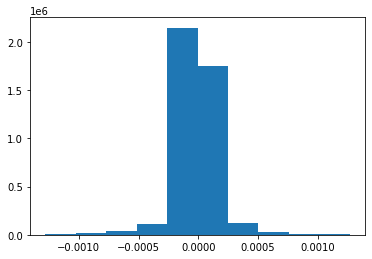

In [21]:
# Plot using object data type
plt.hist(df['channel1'])
plt.show()

<AxesSubplot:xlabel='channel1', ylabel='Count'>

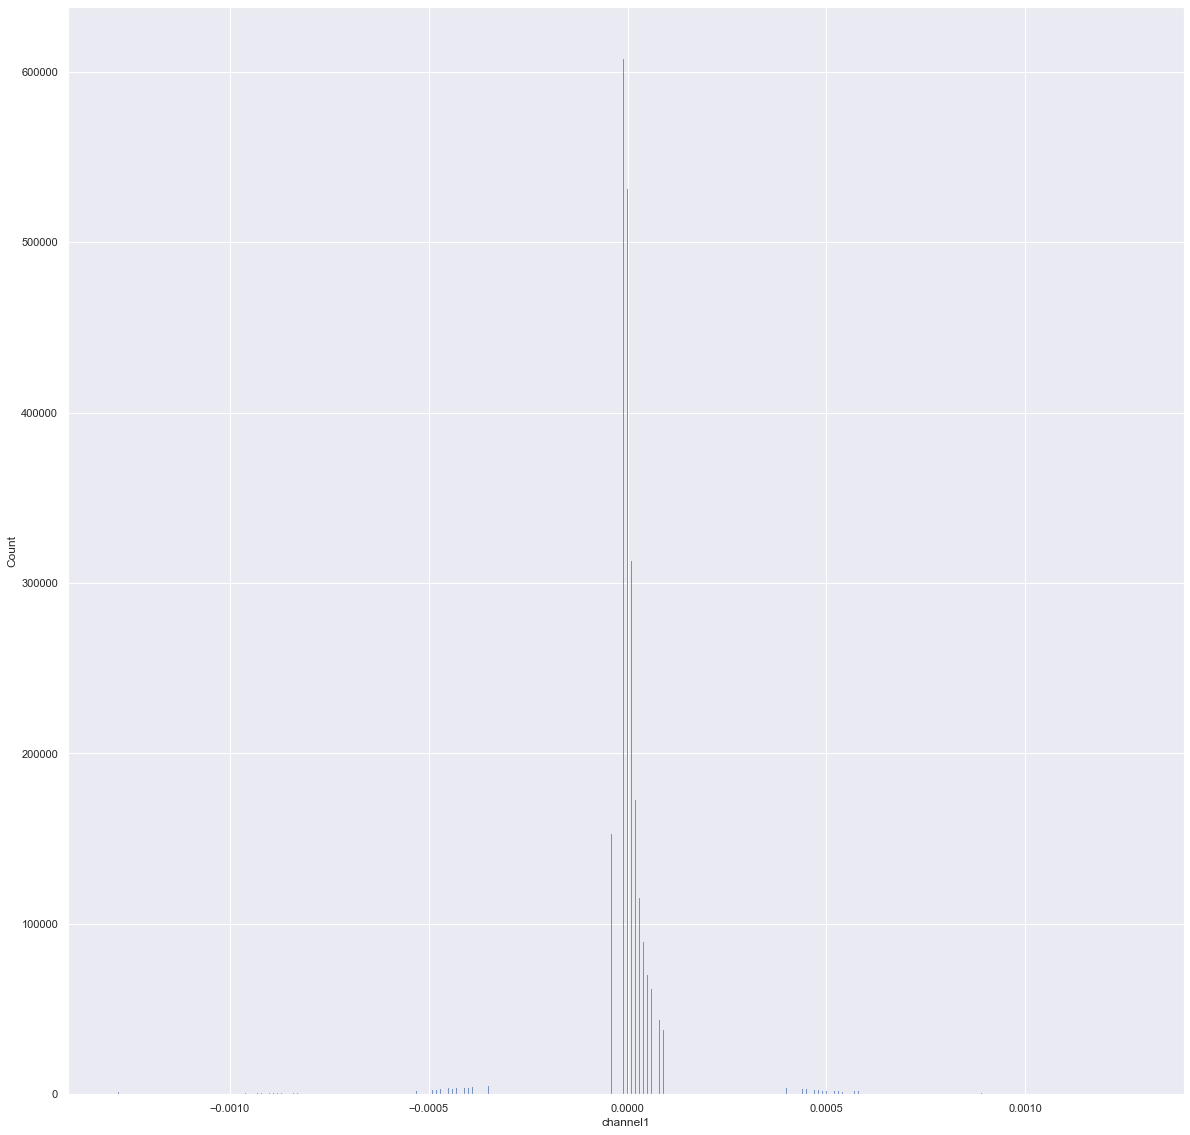

In [220]:
sns.histplot(df['channel1'])

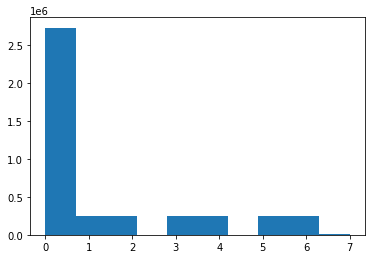

In [22]:
# Histogram of 'class' as a category (not especially useful)
plt.hist(df['class'])
plt.show()

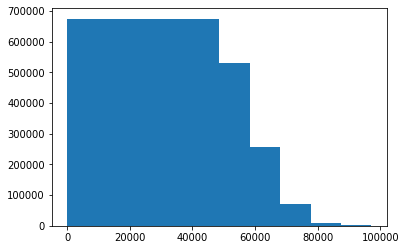

In [25]:
plt.hist(df['time'])
plt.show()

#### Line Plots

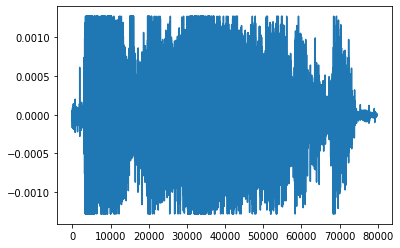

In [26]:
plt.plot(df['channel1'])
plt.show()

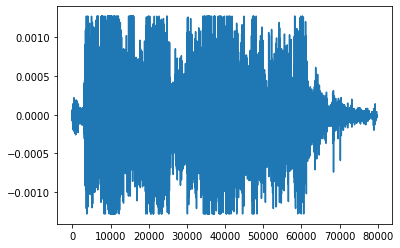

In [27]:
plt.plot(df['channel2'])
plt.show()

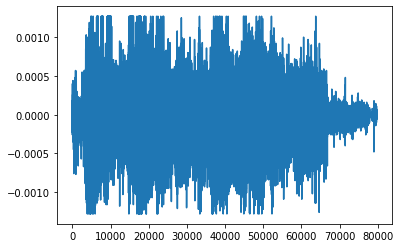

In [28]:
plt.plot(df['channel3'])
plt.show()

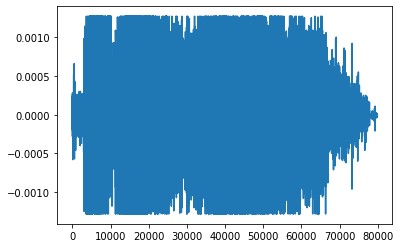

In [29]:
plt.plot(df['channel4'])
plt.show()

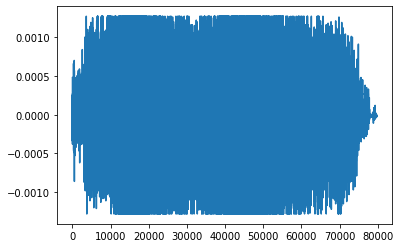

In [30]:
plt.plot(df['channel5'])
plt.show()

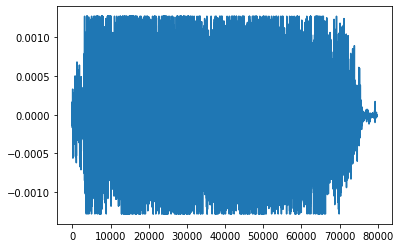

In [31]:
plt.plot(df['channel6'])
plt.show()

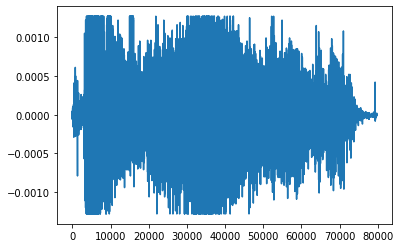

In [32]:
plt.plot(df['channel7'])
plt.show()

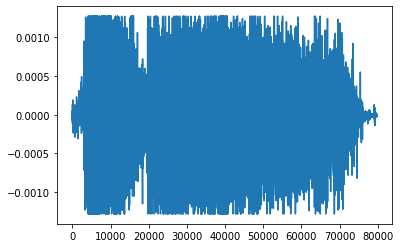

In [33]:
plt.plot(df['channel8'])
plt.show()

#### Scatter Plots

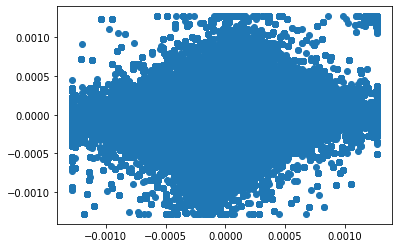

In [34]:
x = df['channel1']
y = df['channel3']
plt.scatter(x,y)
plt.show()

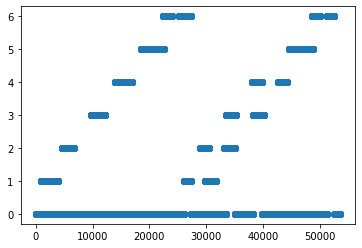

In [35]:
x = df[df['subject']==6]['time']
y = df[df['subject']==6]['class']
plt.scatter(x,y)
plt.show
plt.savefig('time_vs_class.png')

#### Box Plots

In [36]:
header = df.columns
print(header)

Index(['time', 'channel1', 'channel2', 'channel3', 'channel4', 'channel5',
       'channel6', 'channel7', 'channel8', 'class', 'subject'],
      dtype='object')


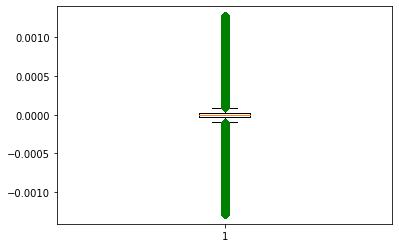

In [37]:
A = df['channel1']
plt.boxplot(A,0,'gD')
plt.show()

#### Other visualizations

<AxesSubplot:label='522985af-ad77-4c9a-9138-35329fe3e61a', xlabel='time', ylabel='values'>

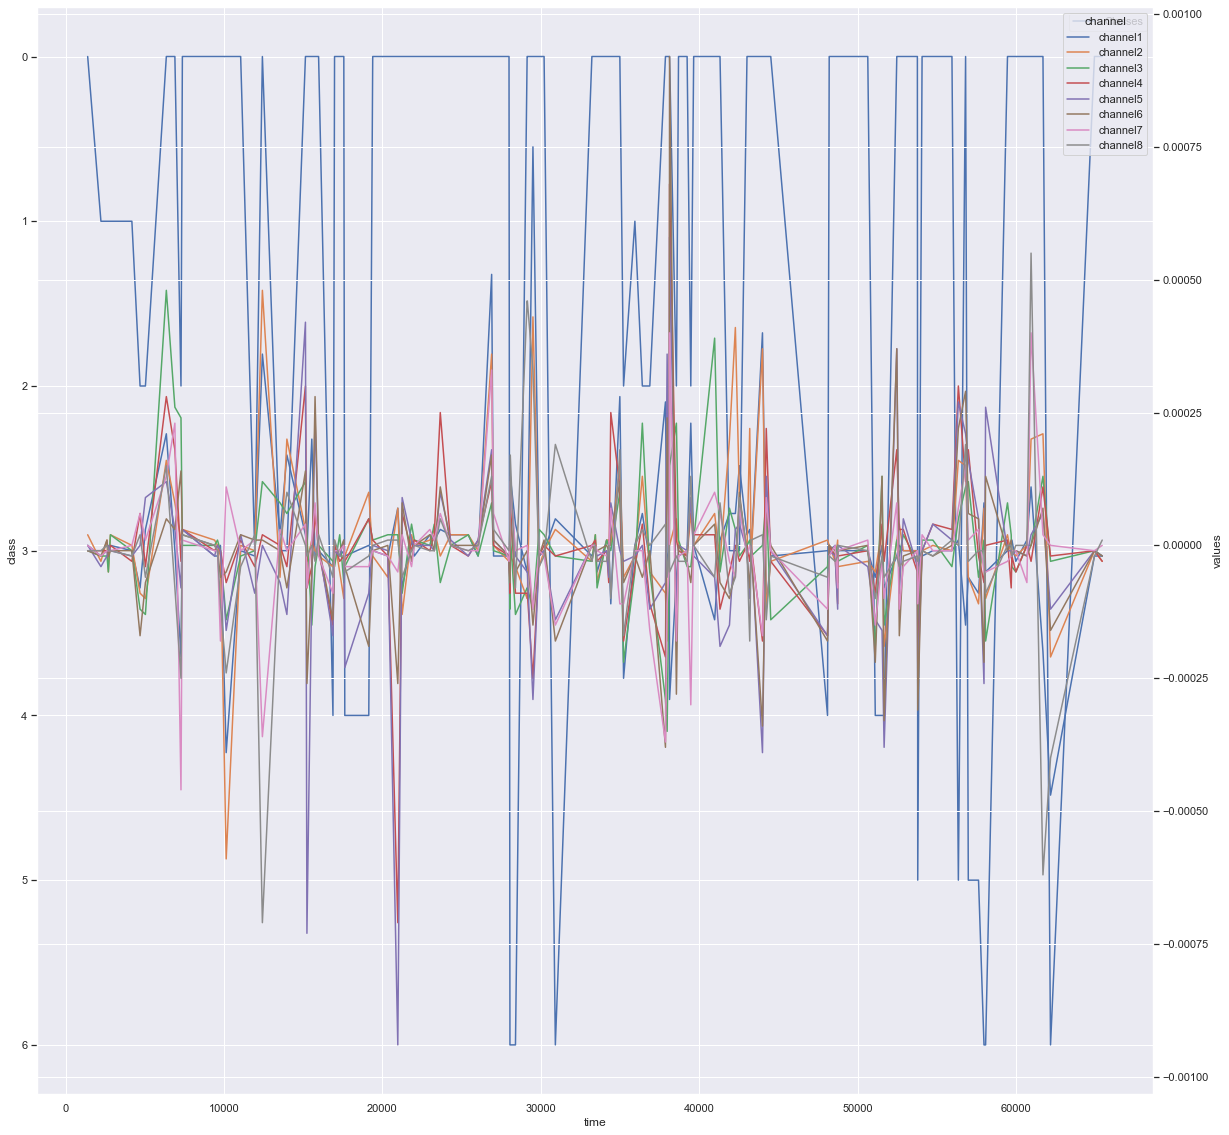

In [223]:
# Plot of all 8 channel values (sampled) superimposed for one subject over the course of both series of gestures.
subj1 = df[df['subject']==1].sample(frac=0.001).copy()
#sns.set(rc={"figure.figsize":(20,20)})
fig, ax = plt.subplots(figsize=(20,20))
sns.lineplot(x='time', y='class', data=subj1[~subj1.index.duplicated()], label='Classes', ax=ax)
ax2 = ax.twinx()
sns.lineplot(x='time', y='values', hue='channel', data=subj1.iloc[:,:-2].melt('time', var_name='channel', value_name='values'), ax=ax2)

<AxesSubplot:xlabel='time', ylabel='values'>

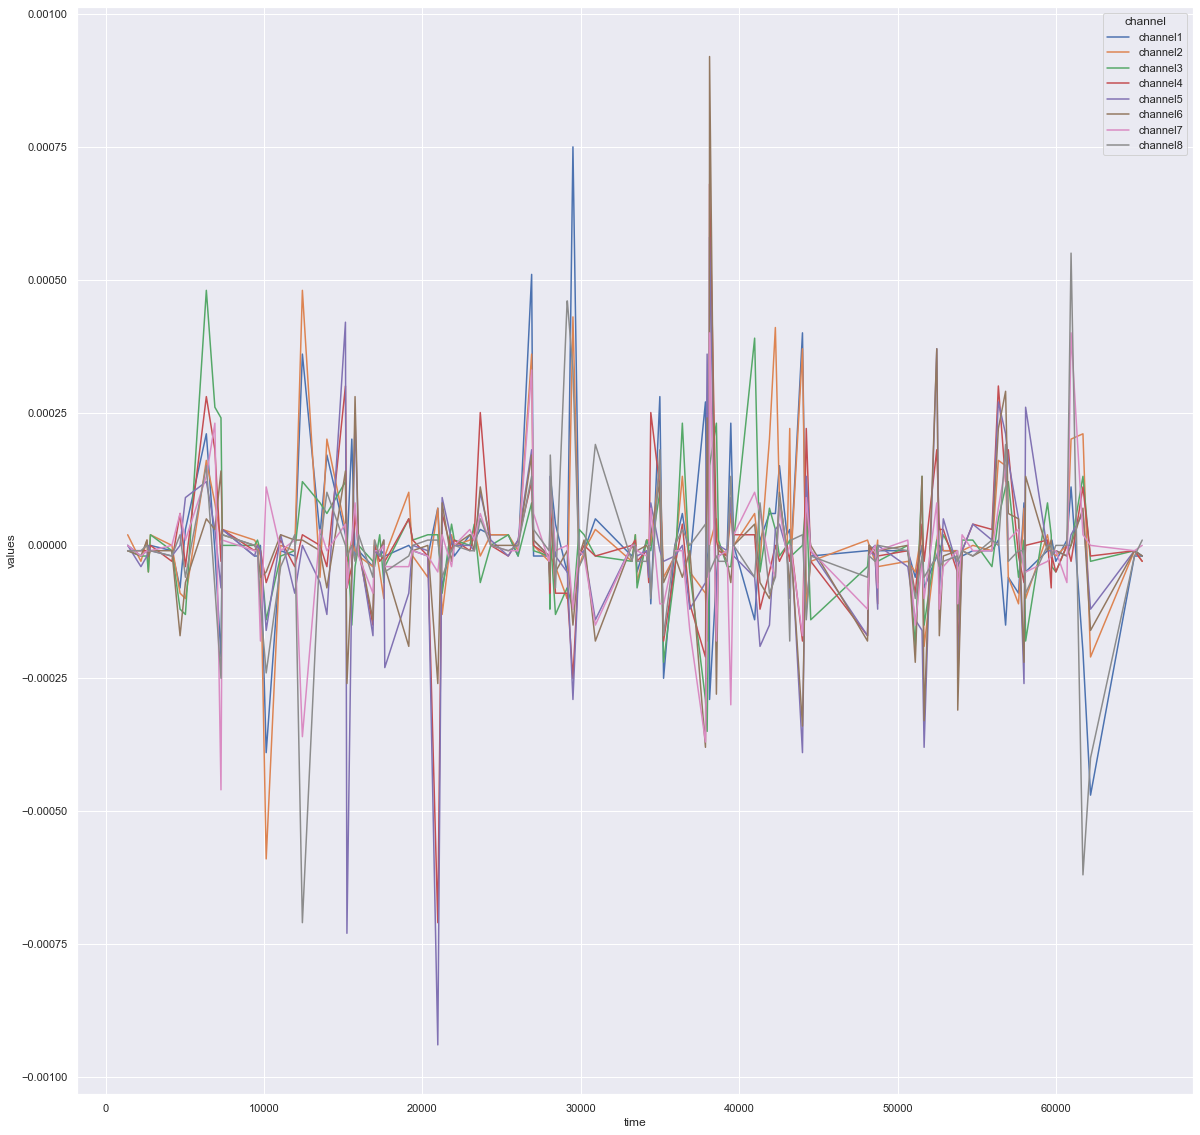

In [225]:
# Without the 'class' plot
fig, ax = plt.subplots(figsize=(20,20))
sns.lineplot(x='time', y='values', hue='channel', data=subj1.iloc[:,:-2].melt('time', var_name='channel', value_name='values'), ax=ax)

## Feature Selection

#### Correlation

In [38]:
corrMat = df.corr()
print(corrMat)

              time  channel1  channel2  channel3  channel4  channel5  \
time      1.000000 -0.000690 -0.001463 -0.001251 -0.000872 -0.003030   
channel1 -0.000690  1.000000  0.356236  0.139168  0.063084  0.043519   
channel2 -0.001463  0.356236  1.000000  0.416788  0.148358  0.069501   
channel3 -0.001251  0.139168  0.416788  1.000000  0.471233  0.136668   
channel4 -0.000872  0.063084  0.148358  0.471233  1.000000  0.385754   
channel5 -0.003030  0.043519  0.069501  0.136668  0.385754  1.000000   
channel6 -0.002844  0.071471  0.103022  0.132106  0.155947  0.332695   
channel7  0.000841  0.109878  0.118788  0.125619  0.093491  0.127081   
channel8 -0.002838  0.318897  0.131197  0.106978  0.063238  0.050743   

          channel6  channel7  channel8  
time     -0.002844  0.000841 -0.002838  
channel1  0.071471  0.109878  0.318897  
channel2  0.103022  0.118788  0.131197  
channel3  0.132106  0.125619  0.106978  
channel4  0.155947  0.093491  0.063238  
channel5  0.332695  0.127081  0.0

<AxesSubplot:>

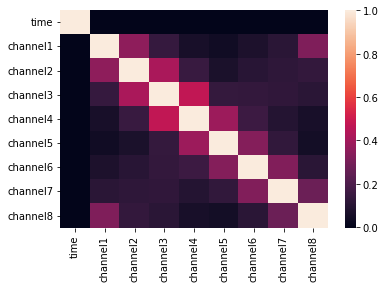

In [39]:
sns.heatmap(corrMat)

Intuitively the correlation between neighboring EMG sensors (the sensors are in an armband form factor) makes sense--it seems reasonable that channel 2 would have some correlation with channels 1 and 3, but not with channels 4-8. Since the sensors wrap all the way around the arm we also have some correlation with channel 1 and 8. However, none of our correlation values are more than 0.5 (channels 3 and 4 have the highest correlation at 0.47).

#### Covariance

In [40]:
covMat = df.cov()
print(covMat)

                  time      channel1      channel2      channel3  \
time      3.489710e+08 -2.102146e-03 -3.257819e-03 -2.901032e-03   
channel1 -2.102146e-03  2.660522e-08  6.927564e-09  2.818966e-09   
channel2 -3.257819e-03  6.927564e-09  1.421409e-08  6.170816e-09   
channel3 -2.901032e-03  2.818966e-09  6.170816e-09  1.542183e-08   
channel4 -3.676129e-03  2.323146e-09  3.993406e-09  1.321220e-08   
channel5 -1.541905e-02  1.933736e-09  2.257281e-09  4.623510e-09   
channel6 -1.143167e-02  2.508042e-09  2.642488e-09  3.529485e-09   
channel7  2.399564e-03  2.737287e-09  2.163007e-09  2.382604e-09   
channel8 -9.124139e-03  8.951532e-09  2.691830e-09  2.286273e-09   

              channel4      channel5      channel6      channel7      channel8  
time     -3.676129e-03 -1.541905e-02 -1.143167e-02  2.399564e-03 -9.124139e-03  
channel1  2.323146e-09  1.933736e-09  2.508042e-09  2.737287e-09  8.951532e-09  
channel2  3.993406e-09  2.257281e-09  2.642488e-09  2.163007e-09  2.691830e-

<AxesSubplot:>

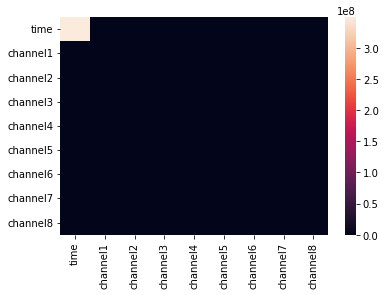

In [41]:
sns.heatmap(covMat)

# Task 3 - Modeling

## Prepare data

#### Unbalanced OOB Data

In [ ]:
# make a copy of the dataframe first
#oob = df.copy()

# pop the DV column into a new dataframe
#oobY = oob.pop('class')
#oobY

# set oobX to be the remaining columns (i.e., the IVs), excluding time
#oobX = oob.iloc[:,1:]
#oobX

#### Unbalanced Sample

In [42]:
# make a copy of the dataframe first
oob = df.sample(frac=0.1).copy()

# pop the DV column into a new dataframe
oobY = oob.pop('class')
oobY

# set oobX to be the remaining columns (i.e., the IVs), excluding time
oobX = oob.iloc[:,1:]
oobX

,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,subject
43389,0.00003,0.00002,0.00000,0.00001,0.00005,0.00008,0.00003,0.00000,5
21891,0.00026,0.00011,0.00012,0.00054,0.00119,0.00063,0.00038,0.00041,16
22353,-0.00002,0.00002,0.00004,0.00054,0.00003,0.00003,-0.00001,0.00000,35
12684,0.00019,-0.00032,0.00053,0.00014,-0.00032,-0.00073,0.00041,0.00024,23
12342,0.00008,-0.00001,0.00000,-0.00002,-0.00006,-0.00019,0.00002,-0.00004,30
...,...,...,...,...,...,...,...,...,...
11352,0.00001,0.00009,-0.00001,0.00040,0.00046,0.00053,0.00015,0.00005,33
15088,-0.00003,-0.00001,0.00001,-0.00032,-0.00019,-0.00010,-0.00015,-0.00009,16
42705,-0.00007,-0.00011,-0.00010,-0.00021,0.00014,-0.00011,-0.00012,-0.00010,24
34772,0.00013,0.00000,-0.00002,0.00012,0.00002,-0.00004,-0.00006,0.00019,24


In [43]:
# We'll also make a version of our IV dataframe that doesn't include 'subject' or 'time'
noSubjectX = oob.iloc[:,1:-1]
noSubjectX

,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8
43389,0.00003,0.00002,0.00000,0.00001,0.00005,0.00008,0.00003,0.00000
21891,0.00026,0.00011,0.00012,0.00054,0.00119,0.00063,0.00038,0.00041
22353,-0.00002,0.00002,0.00004,0.00054,0.00003,0.00003,-0.00001,0.00000
12684,0.00019,-0.00032,0.00053,0.00014,-0.00032,-0.00073,0.00041,0.00024
12342,0.00008,-0.00001,0.00000,-0.00002,-0.00006,-0.00019,0.00002,-0.00004
...,...,...,...,...,...,...,...,...
11352,0.00001,0.00009,-0.00001,0.00040,0.00046,0.00053,0.00015,0.00005
15088,-0.00003,-0.00001,0.00001,-0.00032,-0.00019,-0.00010,-0.00015,-0.00009
42705,-0.00007,-0.00011,-0.00010,-0.00021,0.00014,-0.00011,-0.00012,-0.00010
34772,0.00013,0.00000,-0.00002,0.00012,0.00002,-0.00004,-0.00006,0.00019


## Split/Train/Test

In [52]:
# Sampled OOB dataset

X_trainOOB, X_testOOB, y_trainOOB, y_testOOB = train_test_split(oobX, oobY)   
print( X_trainOOB.shape )
print( y_trainOOB.shape )
print( X_testOOB.shape )
print( y_testOOB.shape )

(317843, 9)
(317843,)
(105948, 9)
(105948,)


In [53]:
# "no subject" dataset

noSubjectX_trainOOB, noSubjectX_testOOB, noSubjectY_trainOOB, noSubjectY_testOOB = train_test_split(noSubjectX, oobY)
print( noSubjectX_trainOOB.shape )
print( noSubjectY_trainOOB.shape )
print( noSubjectX_testOOB.shape )
print( noSubjectY_testOOB.shape )

(317843, 8)
(317843,)
(105948, 8)
(105948,)


##  Create Models

We'll compare a couple of different classification models here:
- Random Forest
- k-Nearest Neighbors
- Extra-Trees

In [54]:
algos = []
algos.append(('RF', RandomForestClassifier(n_jobs=4)))
algos.append(('kNN', KNeighborsClassifier(n_jobs=4)))
algos.append(('ET', ExtraTreesClassifier(n_jobs=4)))

In [243]:
# build sampled OOB models

results = []
names = []

for name, model in algos:
    result = cross_val_score(model, X_trainOOB, y_trainOOB, cv=5, scoring="balanced_accuracy")
    names.append(name)
    results.append(result)

# evaluate results

for i in range(len(names)):
    print(names[i],results[i].mean())

RF 0.6548593054953693
kNN 0.42202444472562917
ET 0.6443745745390792


In [244]:
# build sampled "no subject" models

results = []
names = []

for name, model in algos:
    result = cross_val_score(model, noSubjectX_trainOOB, noSubjectY_trainOOB, cv=5, scoring="balanced_accuracy")
    names.append(name)
    results.append(result)

# evaluate results

for i in range(len(names)):
    print(names[i],results[i].mean())

RF 0.649102631131491
kNN 0.36234185456845674
ET 0.6396410143490427


If the classes were evenly distributed (as they are in our samples) our worst-case accuracy should be 0.125 (1 in 8). Since the classes aren't evenly distributed there's a class imbalance problem and choosing the majority class would be correct about 64% of the time in the full dataset.

## Validate

In [245]:
# select best model(s) to tune and validate with the test set

# the best model above was the random forest model on the sampled dataset, so we'll start with that
bestAlgo = RandomForestClassifier(n_jobs=4)
cv = cross_validate(bestAlgo, X_trainOOB, y_trainOOB, cv=5, scoring="balanced_accuracy", return_estimator=True)
#bestAlgo.fit(X_trainOOB, y_trainOOB)
#bestAlgoOOBpred = bestAlgo.predict(X_testOOB)

In [246]:
#cv.keys()
cv['test_score']

array([0.65152181, 0.65380902, 0.65406834, 0.65682861, 0.65718087])

In [247]:
# the fourth estimator has the best score, so use it to predict against the test set
bestAlgoOOBpred = cv['estimator'][4].predict(X_testOOB)

In [248]:
cv['estimator'][4].feature_importances_

array([0.10785062, 0.10279757, 0.10821418, 0.12487716, 0.12311176,
       0.11110729, 0.10804604, 0.11224907, 0.10174632])

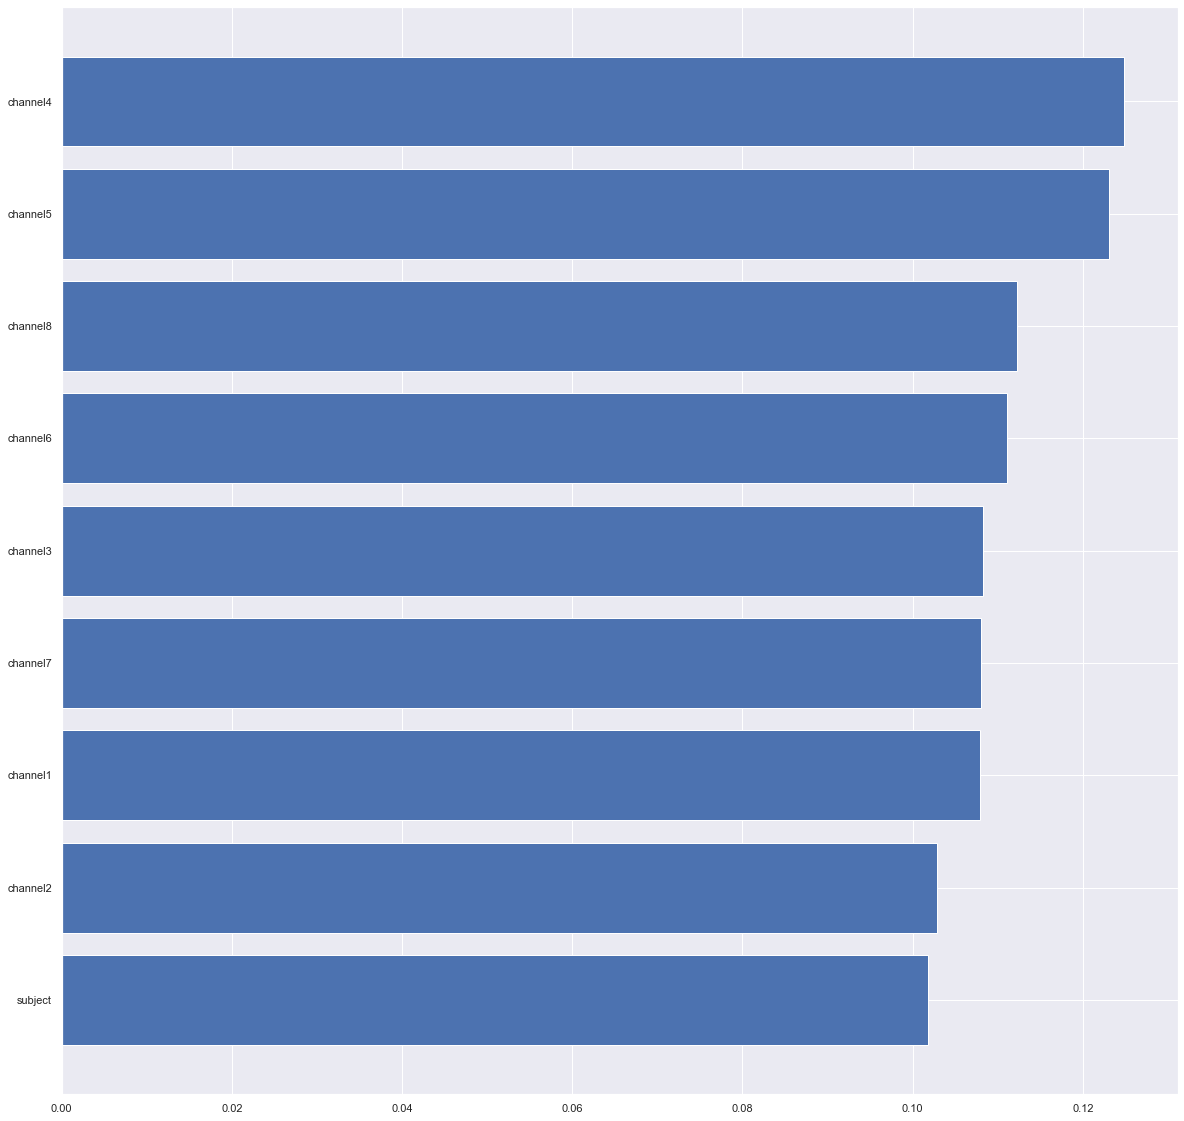

In [249]:
importances = cv['estimator'][4].feature_importances_

indices = np.argsort(importances)

fig, ax = plt.subplots()
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(X_trainOOB.columns)[indices])

In [250]:
# check the default parameters
cv['estimator'][4].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 4,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [260]:
print(classification_report(y_testOOB, bestAlgoOOBpred))
print(multilabel_confusion_matrix(y_testOOB, bestAlgoOOBpred))
print(balanced_accuracy_score(y_testOOB, bestAlgoOOBpred))

              precision    recall  f1-score   support

         0.0       0.82      0.98      0.89     68256
         1.0       0.96      0.59      0.73      6074
         2.0       0.91      0.62      0.74      6045
         3.0       0.93      0.61      0.74      6394
         4.0       0.90      0.63      0.74      6223
         5.0       0.95      0.62      0.75      6421
         6.0       0.91      0.61      0.73      6210
         7.0       1.00      0.59      0.74       325

    accuracy                           0.85    105948
   macro avg       0.92      0.66      0.76    105948
weighted avg       0.86      0.85      0.84    105948

[[[ 23405  14287]
  [  1568  66688]]

 [[ 99739    135]
  [  2505   3569]]

 [[ 99545    358]
  [  2315   3730]]

 [[ 99251    303]
  [  2493   3901]]

 [[ 99263    462]
  [  2272   3951]]

 [[ 99301    226]
  [  2469   3952]]

 [[ 99358    380]
  [  2396   3814]]

 [[105623      0]
  [   133    192]]]
0.655884918674366


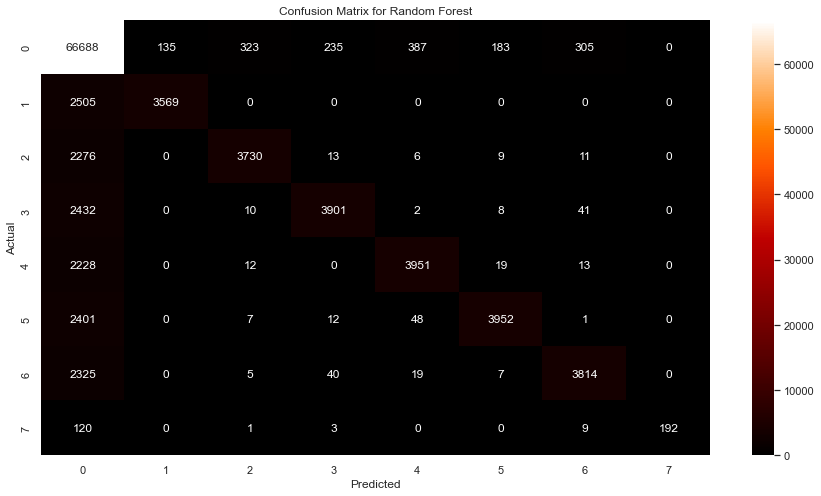

In [261]:
y_true = np.array(y_testOOB)
y_pred = np.array(bestAlgoOOBpred)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize = (15,8))
sns.heatmap(cm, annot=True, fmt='g', cmap='gist_heat', cbar=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Random Forest")
plt.show()

In [254]:
# results are okay, but let's see if we can tune them
# we'll use balanced_accuracy as our scorer since we have a very unbalanced dataset
tunedAlgo = GridSearchCV(RandomForestClassifier(), param_grid=[{"n_estimators":[10,20,30,40,50,75,100,150,175]}], cv=5, n_jobs=-1, return_train_score=True, scoring="balanced_accuracy")

In [255]:
tunedAlgo.fit(X_trainOOB, y_trainOOB)
tunedAlgoOOBpred = tunedAlgo.predict(X_testOOB)

In [256]:
tunedAlgo.cv_results_

{'mean_fit_time': array([ 10.5113894 ,  17.94010816,  24.55831313,  36.47549686,
         47.48671551,  79.29980001,  91.54147038, 131.49884825,
        132.61639185]),
 'std_fit_time': array([ 0.07964674,  0.43910343,  0.75456621,  0.71871999,  1.7996389 ,
         2.5210249 ,  1.92732269,  0.8216496 , 12.42402739]),
 'mean_score_time': array([0.53101435, 0.99002585, 1.52216711, 2.20200405, 2.66065836,
        4.17662473, 5.26005073, 7.45385914, 6.05933156]),
 'std_score_time': array([0.01496521, 0.07995612, 0.11798844, 0.10152704, 0.18321513,
        0.25804649, 0.66191822, 0.70057983, 1.3320848 ]),
 'param_n_estimators': masked_array(data=[10, 20, 30, 40, 50, 75, 100, 150, 175],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 10},
  {'n_estimators': 20},
  {'n_estimators': 30},
  {'n_estimators': 40},
  {'n_estimators': 50},
  {'n_estimators': 75},

In [257]:
tunedAlgo.best_estimator_

RandomForestClassifier(n_estimators=30)

In [127]:
tunedAlgo.best_score_

0.6584235194117893

In [129]:
tunedAlgo.n_features_in_

9

In [262]:
print(classification_report(y_testOOB, tunedAlgoOOBpred))
print(multilabel_confusion_matrix(y_testOOB, tunedAlgoOOBpred))
print(balanced_accuracy_score(y_testOOB, tunedAlgoOOBpred))

              precision    recall  f1-score   support

         0.0       0.85      0.97      0.91     68256
         1.0       0.96      0.66      0.78      6074
         2.0       0.91      0.69      0.78      6045
         3.0       0.93      0.69      0.79      6394
         4.0       0.90      0.70      0.79      6223
         5.0       0.93      0.69      0.79      6421
         6.0       0.91      0.69      0.79      6210
         7.0       1.00      0.66      0.79       325

    accuracy                           0.87    105948
   macro avg       0.92      0.72      0.80    105948
weighted avg       0.88      0.87      0.87    105948

[[[ 26233  11459]
  [  1725  66531]]

 [[ 99718    156]
  [  2077   3997]]

 [[ 99502    401]
  [  1889   4156]]

 [[ 99214    340]
  [  1980   4414]]

 [[ 99249    476]
  [  1856   4367]]

 [[ 99216    311]
  [  1996   4425]]

 [[ 99326    412]
  [  1921   4289]]

 [[105622      1]
  [   112    213]]]
0.718445579112611


In [263]:
tunedAlgoOOBpred

array([0., 1., 0., ..., 0., 0., 0.])

In [264]:
y_trainOOB

/usr/local/lib/python3.9/site-packages/pandas/io/formats/format.py:1405: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


19827    0.0
7774     0.0
34573    0.0
16881    0.0
3398     0.0
        ... 
21433    0.0
66389    6.0
473      0.0
24894    0.0
21745    0.0
Name: class, Length: 317843, dtype: category
Categories (8, float64): [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]

In [265]:
print(y_trainOOB.iloc[1221])
print(tunedAlgoOOBpred[1221])

6.0
0.0


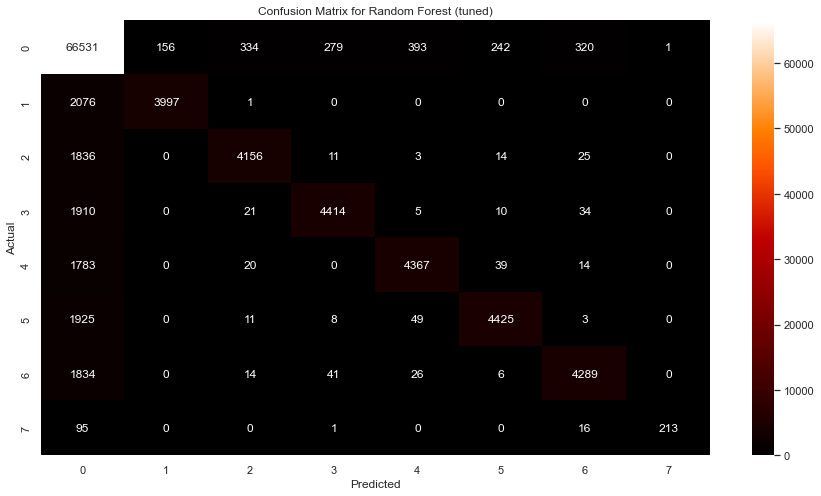

In [266]:
y_true = np.array(y_testOOB)
y_pred = np.array(tunedAlgoOOBpred)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize = (15,8))
sns.heatmap(cm, annot=True, fmt='g', cmap='gist_heat', cbar=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Random Forest (tuned)")
plt.show()

In [267]:
# Save trained model
joblib.dump(tunedAlgo, "trainedModel.pkl")

['trainedModel.pkl']

In [130]:
# Load trained model
trainedModel = joblib.load("trainedModel.pkl")

In [132]:
trainedModel.best_estimator_

ExtraTreesClassifier(n_estimators=10)